In [11]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from visualize.image_points import *
from visualize.read_positions import read_positions
from visualize.perspective import *
import random
%matplotlib inline
import random
from visualize.helper import *
from visualize.layout import *


In [4]:
def create_full_heatmap(df, save_path, days_interval=10, min_scale=20, title=None):
    camera_ids = [2, 4, 6, 7]
    raw_heatmaps = []
    heatmap_1 = get_heatmap_new(df, [1,2], CAMERA_to_MAP[1])
    raw_heatmaps.append(heatmap_1)
    for camera in camera_ids[1:]:
        raw_heatmaps.append(get_heatmap_new(df, [camera], CAMERA_to_MAP[camera]))
    global_max = np.max([np.max(heatmap) for heatmap in raw_heatmaps])

    def normalize_and_apply_colormap(heatmap, global_max, min_scale=min_scale):
        # Scale heatmap values based on global_max directly
        heatmap_scaled = (heatmap / global_max) * 255 
        heatmap_scaled = np.clip(heatmap_scaled, 0, 255).astype(np.uint8)  # Ensure values are within byte range
        zero_mask = (heatmap_scaled < 255/min_scale)

        heatmap_color = cv2.applyColorMap(heatmap_scaled, cv2.COLORMAP_JET)
        heatmap_color[zero_mask] = (0,0,0)
        return heatmap_color

    normalized_heatmaps = [normalize_and_apply_colormap(heatmap, global_max) for heatmap in raw_heatmaps]

    
    original_img = cv2.imread(CAMERA_to_PATH[1])
    # plot_images(original_img)
    heatmap_color = normalized_heatmaps[0]
    overlayed_img1 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    
    original_img = cv2.imread(CAMERA_to_PATH[7])
    heatmap_color = normalized_heatmaps[3]
    overlayed_img7 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    
    original_img = cv2.imread(CAMERA_to_PATH[6])
    heatmap_color = normalized_heatmaps[2]
    overlayed_img6 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    
    original_img = cv2.imread(CAMERA_to_PATH[4])
    heatmap_color = normalized_heatmaps[1]
    overlayed_img4 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)

    final_layout = create_layout(overlayed_img1, overlayed_img4, overlayed_img6, overlayed_img7)

    max_per_day = global_max/days_interval
    
    fig = add_colorbar(final_layout, max_per_day/min_scale, max_per_day, title)
    fig.savefig(save_path, bbox_inches='tight')

def one_heatmap(df, camera, min_scale=20):
    heatmap = get_heatmap_new(df, camera, CAMERA_to_MAP[camera[0]])
    global_max = np.max(heatmap)
    heatmap_scaled = (heatmap / global_max) * 255 
    heatmap_scaled = np.clip(heatmap_scaled, 0, 255).astype(np.uint8)  # Ensure values are within byte range
    zero_mask = (heatmap_scaled < 255/min_scale)

    heatmap_color = cv2.applyColorMap(heatmap_scaled, cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    
    original_img = cv2.imread(CAMERA_to_PATH[camera[0]])
    overlayed_img = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    plt.figure()
    plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
    plt.show()
    return overlayed_img

In [12]:
df = read_positions(label_dir='../data_all/labels', output_csv='visualize/positions.csv')
target_date = pd.to_datetime('2024-01-21').date() 
df = df[df['Date'].dt.date != target_date]
df.head(11)
len(df)
date_diff = (df['Date'].max() - df['Date'].min()).days
print(f"Difference in days: {date_diff}")

Difference in days: 36


In [6]:
df_proj = project_df(df)
print(f'LEN = {len(df_proj)}')
df_proj.head()
df_proj['Camera'].value_counts()
df_proj = remove_duplicate_elephants(df_proj)
df_proj['Camera'].value_counts()

/home/improcloud/nguyehu7/BP/visualize/perspective.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)


LEN = 8045


Camera
2    2507
7    2169
1    1382
6     933
4     564
Name: count, dtype: int64

In [7]:
def heatmap_by_hour(df_proj, hour_sampling, days_interval):

    df_proj['Hour'] = df_proj['Date'].dt.hour
    def map_to_time_window(hour):
        return f'{int(np.floor(hour / hour_sampling) * hour_sampling):02d}-{int(np.floor(hour / hour_sampling) * hour_sampling + hour_sampling):02d}'
        
    df_proj['Time_Window'] = df_proj['Hour'].apply(map_to_time_window)
    df_proj[['Hour', 'Time_Window']]
    time_windows = df_proj['Time_Window'].unique().tolist()
    time_windows.sort()
    def all_heatmaps_exist(time_windows):
        for tw in time_windows:
            save_path = f'tmp_heatmaps/he{tw}.png'
            if not os.path.exists(save_path):
                return False  
        return True 
    if not all_heatmaps_exist(time_windows):
        for tw in time_windows:
            df = df_proj[df_proj['Time_Window'] == tw]
            create_full_heatmap(df=df, save_path=f'tmp_heatmaps/he{tw}.png', title=tw, days_interval=days_interval)
    else:
        print('Heatmaps already cached.')
    image_paths = [f"tmp_heatmaps/he{x}.png" for x in time_windows]
    images = [cv2.imread(path) for path in image_paths]
    rows = [cv2.hconcat(images[i:i+int(24/hour_sampling/4)]) for i in range(0, 24//hour_sampling, int(24/hour_sampling/4))]
    # Vertically concatenate the rows to form the final grid
    stacked_image = cv2.vconcat(rows)
    plot_images(stacked_image, height=200, width=200)
    cv2.imwrite('he_all.png', stacked_image)


Heatmaps already cached.


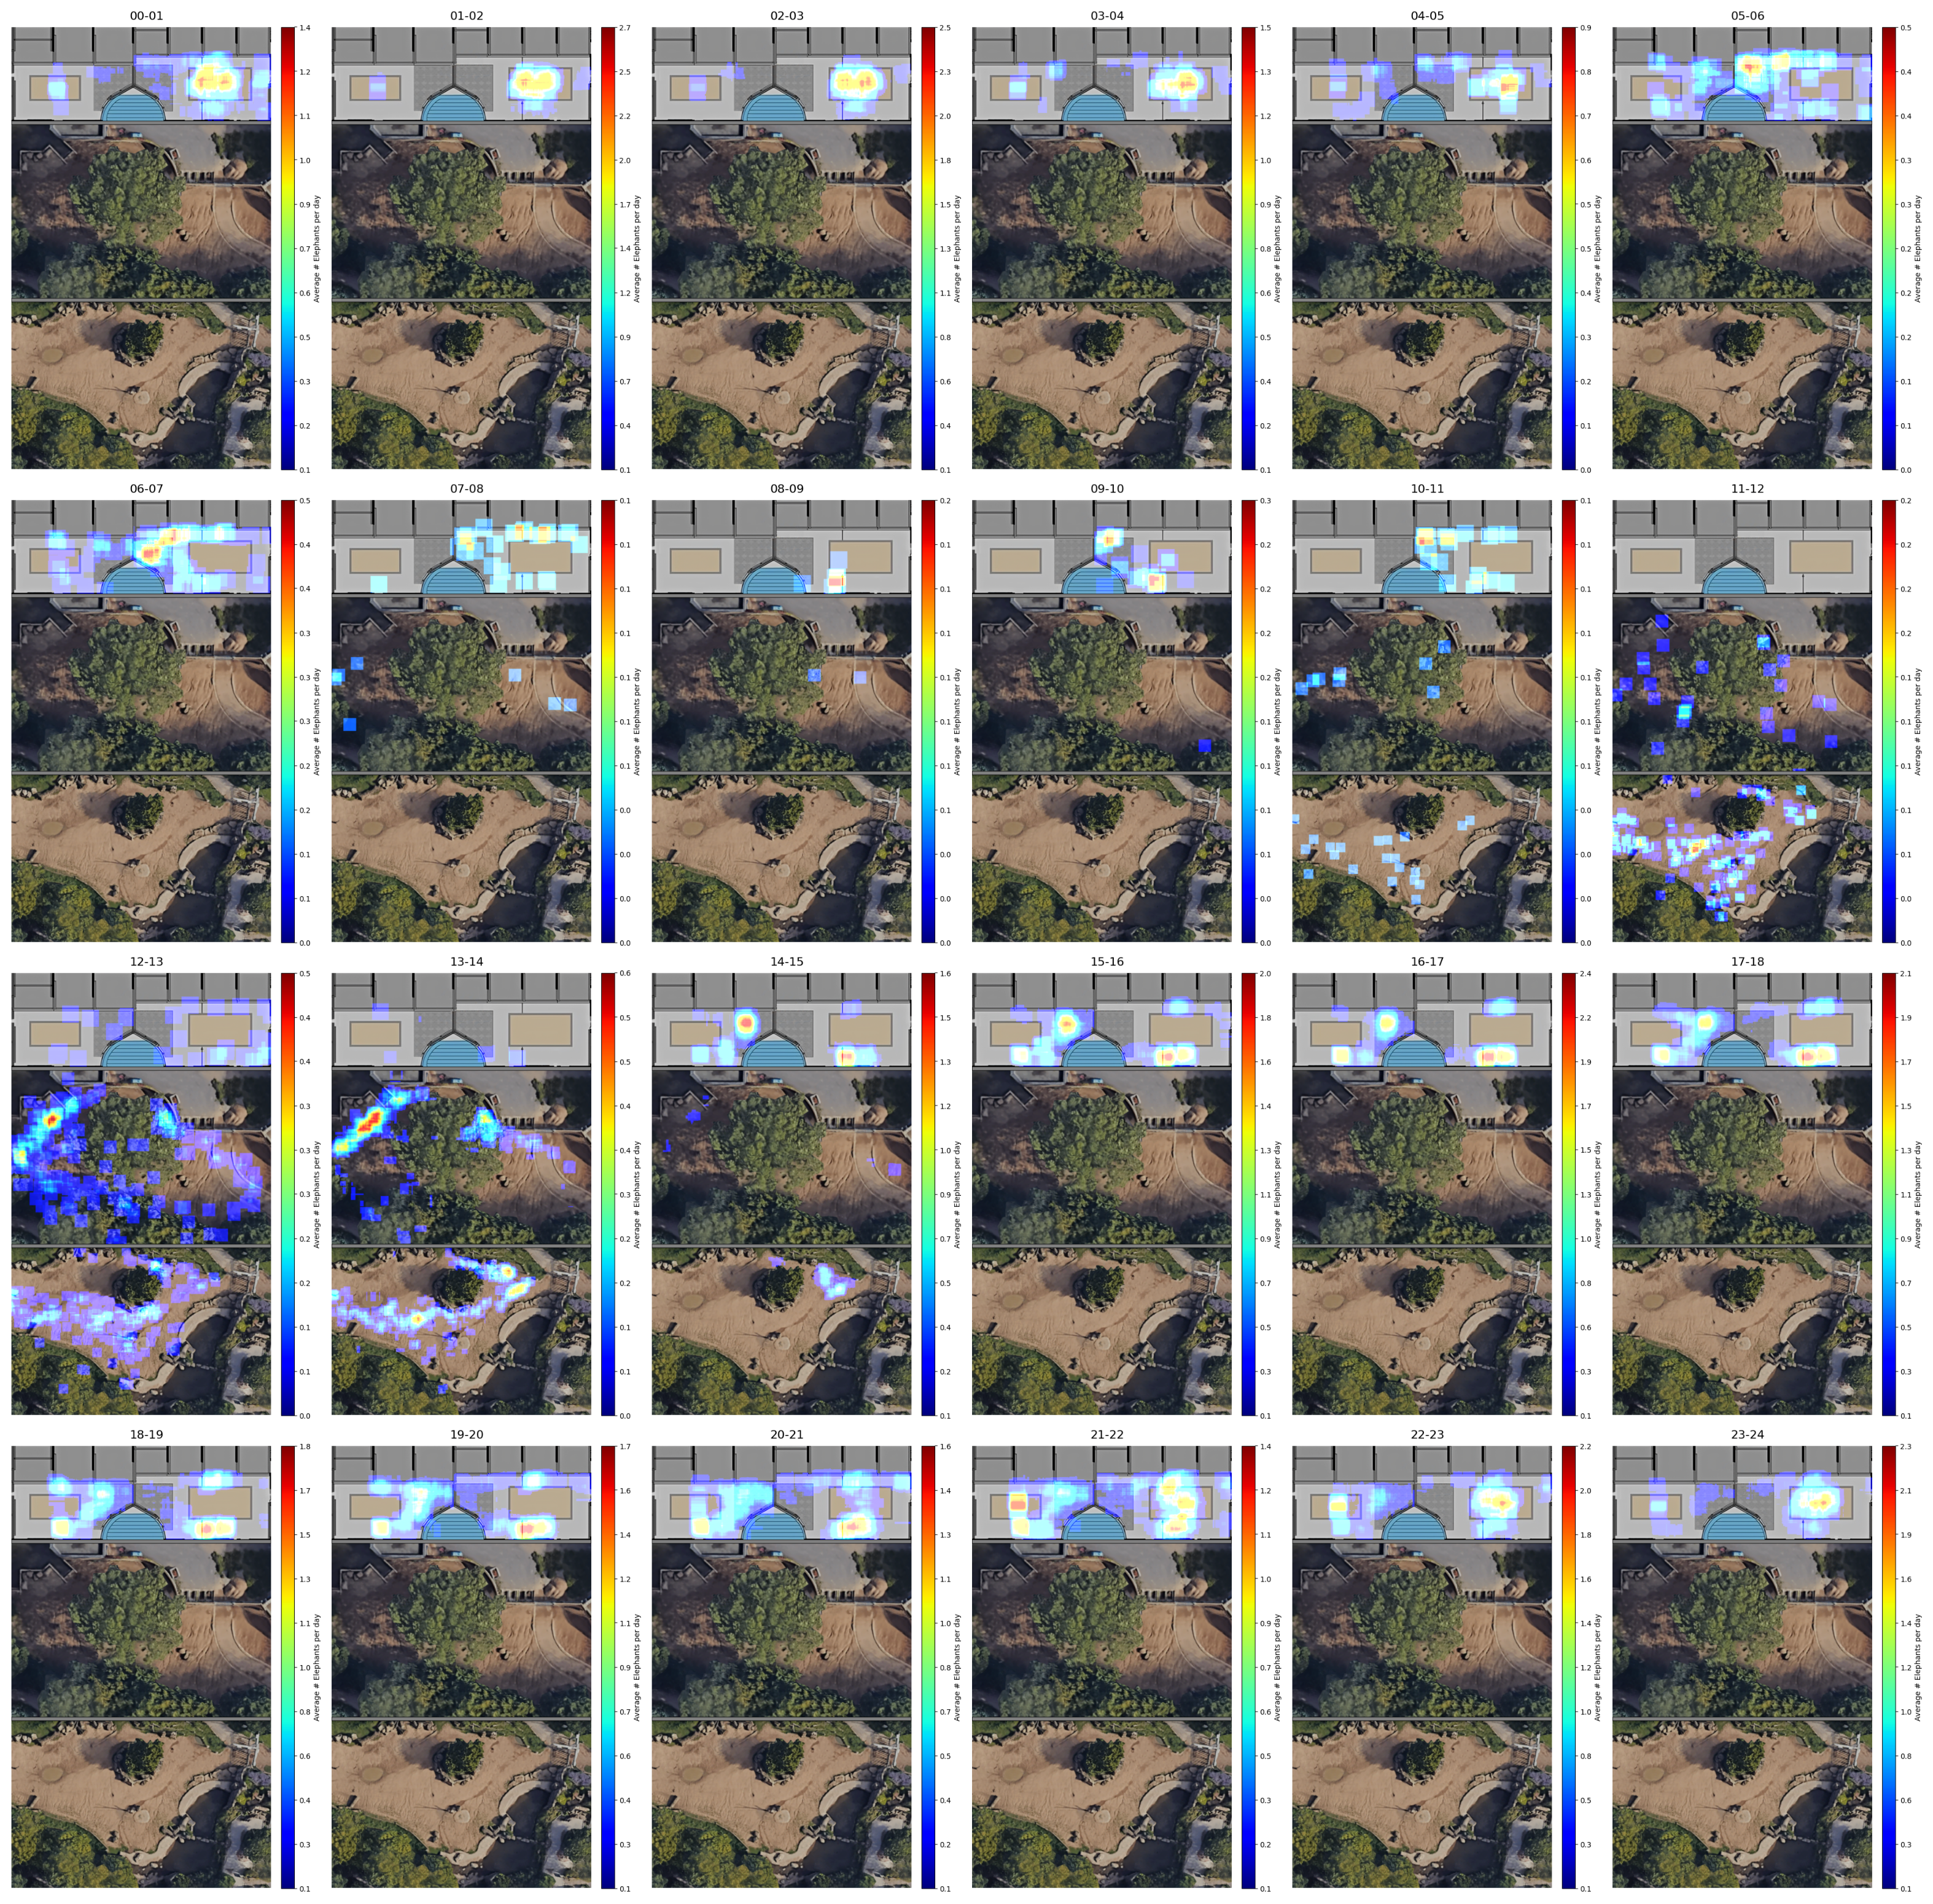

In [8]:
HOUR_SAMPLING = 1 # DO ONLY DIVISORS OF 24
heatmap_by_hour(df_proj=df_proj, hour_sampling=HOUR_SAMPLING, days_interval=date_diff+1)

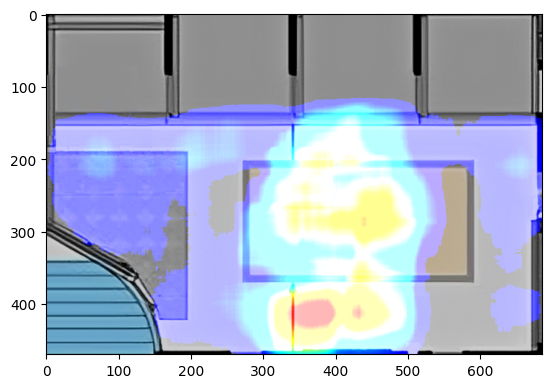

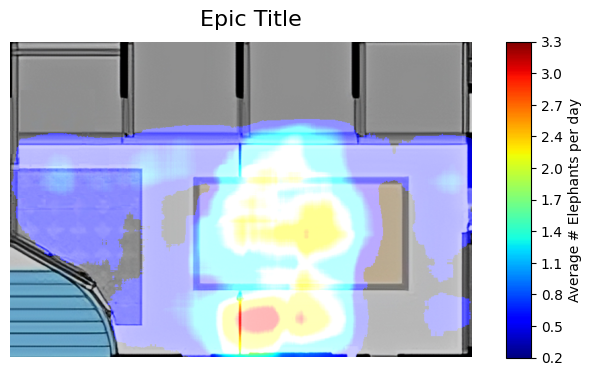

In [10]:
# # Optionally, load an actual image to overlay the heatmap on

# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import numpy as np

# def add_colorbar_image(image, min_val, max_val, title=None, show=False):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4),
#                                    gridspec_kw={'width_ratios': [20, 1], 'wspace': 0.05})
#     if title is not None:
#         fig.suptitle(title, fontsize=16)
        
#     # Display the image in the first subplot
#     ax1.imshow(image[..., ::-1]) 
#     ax1.axis('off')  # Turn off axis for image
    
#     # Create a colormap and normalization instance
#     cmap = mpl.cm.jet
#     norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
    
#     # Create the colorbar in the second subplot
#     cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
#     cb1.set_label('Average # Elephants per day')
#     # Set custom ticks if needed (here just showing min and max)
#     tick_values = np.linspace(min_val, max_val, num=11)
#     cb1.set_ticks(tick_values)
#     cb1.set_ticks(tick_values)
#     # cb1.set_ticklabels([f'{min_val}', f'{max_val}'])
#     cb1.set_ticklabels([f'{val.round(1)}' for val in tick_values])
#     if not show:
#         plt.close()
#     #fig.tight_layout()
#     fig.subplots_adjust(top=0.90)
#     return fig


l = one_heatmap(df_proj, [1,2])
fig = add_colorbar_image(l, 3.3/20, 3.3, 'Epic Title', show=True)